In [1]:
import re
import os
import sys
from lca_algebraic import initProject
import pandas as pd
import numpy as np
import xarray as xr
import lca_algebraic as agb
from lca_algebraic import *
from lca_algebraic.stats import * 
import bw2data, bw2io
import bw2calc
from premise import *
import premise as prm
from itertools import zip_longest
from scipy.integrate import cumtrapz

In [2]:
sys.path.append('/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/') 
from utils import *
from utils.setup import *
from utils.setup_whdLCIA import *
from utils.getAct import *
from utils.utils import *
from utils.dlcia_functions import *

modify the setup.py file for reading Parameter excel sheet. here we use 'data/p_file/p_tech_perSSP_Y.xlsx' as the technology parameter file.  
Define your chosen methods in the setup.py file. Current methods are:  [('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')]
Mapping premise_remind_DB to SSPx:  {'SSP1-PkBudg500': 'ssp119', 'SSP1-PkBudg1150': 'ssp126', 'SSP2-Base': 'ssp245', 'SSP5-Base': 'ssp585'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pGWP100 are imported as:  [('IPCC 2021 - dpCFsSSP119_MY2030 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP245_MY2030 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP585_MY2030 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP119_MY2040 - year100', 'climate change', 'pGWP100'), ('IPCC 2021 - dpCFsSSP245_MY2040 - year100', 'climate cha

In [3]:
bw2data.projects.set_current('iveo_v1')
mybio = bw2data.Database("biosphere3")
initProject("iveo_v1")

Biosphere database already present!!! No setup is needed


In [4]:
print( ssp_scn  , ssp_yr) 
bw2_method_metric = 'dpIRF'

root_path = '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/'
#tech_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/p_tech_perSSP_Y.xlsx'))
consmp_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/tech_conversion_veh_p/p_scn_v_need_tech.xlsx'))

['_remind_SSP1-PkBudg500', '_remind_SSP2-Base', '_remind_SSP5-Base'] [2030, 2040, 2050]


In [5]:
v_lifetime = 20
v_yearlyFU = [36000] * v_lifetime 

### init 

In [6]:
pdb = bw.Database("iveo_Parameterized_v1")
print(len(pdb))
#resetParams()
agb.loadParams()
agb.list_parameters()

384


[ParamRegistry] Param NMC622_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param NCA_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LFP_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LTO_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_NG_MJperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_elec_kWhperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param g_truck_vehicle_prod_lightweighting was already defined in '<project>' : overriding.
[ParamRegistry] Param battery_total_capacity_for_gtruck was already defined in '<project>' : overriding.
[ParamRegistry] Param biodiesel_UCO_perc was already defined in '<project>' : overriding.
[ParamRegistry] Pa

group,name,label,default,min,max,std,distrib,unit,db
battery,LFP_battery_cell_density,LFP battery cell density,0.21054,0.2,0.308252,,triangle,kWh/kg,[project]
battery,LSB_battery_cell_density,LSB battery cell density,0.5,0.2954,0.73,,triangle,kWh/kg,[project]
battery,LSB_cell_assmb_NG_MJperkg,LSB cell assmb NG MJperkg,5.47,2.88,5.47,,linear,MJ,[project]
battery,LSB_cell_assmb_elec_kWhperkg,LSB cell assmb elec kWhperkg,1.38,0.65,1.38,,linear,kWh,[project]
battery,LTO_battery_cell_density,LTO battery cell density,0.21054,0.2,0.308252,,triangle,kWh/kg,[project]
battery,NCA_battery_cell_density,NCA battery cell density,0.303589,0.25,0.444485,,triangle,kWh/kg,[project]
battery,NMC622_battery_cell_density,NMC622 battery cell density,0.29161,0.25,0.426946,,triangle,kWh/kg,[project]
diesel,biodiesel_UCO_perc,biodiesel UCO perc,0.011,0.00925,0.01225,,linear,fraction,[project]
diesel,biodiesel_algea_perc,biodiesel algea perc,0.011,0.00925,0.01225,,linear,fraction,[project]
diesel,biodiesel_rapeseedoil_perc,biodiesel rapeseedoil perc,0.011,0.00925,0.01225,,linear,fraction,[project]


### get already created UPRs:

In [7]:
gtruck_finalelec_switch_allsspyear = [] 
for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        bg_db_ssp_yr = bg_ei_ + prm_name + "_" + str(year_t)            # backgroun database (BD) to use for SSP[x], Year[t]
        copied_prm_UPR_suffix = "_from_" + prm_name + "_" + str(year_t) # copy UPR from BD to PDB for further use/modification if needed
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t)          # naming on any new UPRs created in PDB
        act = agb.findActivity( db_name = PDB_NAME, name="elec_tech_switch_act" + newUPR_suffix )
        gtruck_finalelec_switch_allsspyear.append(act)

len(gtruck_finalelec_switch_allsspyear)

9

### read in TRL table to see which switch_P to apply

In [8]:
data = xr.open_dataset( os.path.abspath(os.path.join(root_path, 'data/to_use_interm/TRL_1C_vehDSwhTRL.nc')))
data2 = data.where(data["tech_avail"] == 1, drop = True) 
data2

<xarray.Dataset>
Dimensions:     (v_type: 1, size: 1, powertrain: 2, v_year: 3, SSP: 4,
                 Module: 5, Tech: 9)
Coordinates:
  * Tech        (Tech) object 'LIB_LFP' 'LIB_LTO' ... 'dummy_tech' 'grid_elec'
  * Module      (Module) object 'F2_fuel_diesel' 'F2_fuel_elec' ... 'V2_oper'
  * SSP         (SSP) object 'ssp119' 'ssp126' 'ssp245' 'ssp585'
  * v_year      (v_year) int32 2030 2040 2050
  * powertrain  (powertrain) object 'BEV' 'ICEV-d'
  * v_type      (v_type) object 'garbage_truck'
  * size        (size) object 'HDV_class7'
Data variables:
    TRL         (v_type, size, powertrain, v_year, SSP, Module, Tech) float64 ...
    tech_appl   (v_type, size, powertrain, v_year, SSP, Module, Tech) float64 ...
    tech_avail  (v_type, size, powertrain, v_year, SSP, Module, Tech) float64 ...

### C.2 read all P file - 
for electricity, it's just a tech_switch parameter on production tech there is no yearlyParams to run 
#### though, the consumption amount of elec. consumption is a parameter file located in under 
        "self.fpath = fpath     #os.path.join('data/P_files/tech_conversion_veh_p/', 'p_scn_v_need_tech.xlsx')" 


#### C.2.0 testing reading P file  (for elec, it's the annual consumption value)

In [9]:
v_lifetime = 20
v_yearlyFU = [36000] * v_lifetime  #assuming each year running same mileage

for act_tocalc in gtruck_finalelec_switch_allsspyear:
    #print(act_tocalc)
    # need a matched YearlyParams for each SSPx:
    str1 = act_tocalc.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
    """ will read v_pneed for each running_Y in calc """
    v_pneed = loadYearlyParamswhsize(PARAMS_FILE = consmp_p_file, s_name = 'g_truck', hypothesis = 'point value', 
                               years = [year_to_get_inP], SSP = ssp_to_get_inP, size = 'HDV_class7')
    print(ssp_to_get_inP,year_to_get_inP,v_pneed )
    """ final run year should be v_lifetime, if assuming it starts running from YEAR[0], then no need to adding (v_lifetime+1) in range() """ 
    for Y in range(year_to_get_inP+1, year_to_get_inP + v_lifetime + 1,  1):  
        elec_consumperyear = get_f2_fuel_elec_kwh(Y = Y,  v_lifetime = v_lifetime, v_yearlyFU = v_yearlyFU , 
                                                  SP = ssp_to_get_inP, year_inP = year_to_get_inP, v_pneed = v_pneed  )

ssp119 2030 {'diesel_consump_perkm': [0.39899999999999997], 'elec_consump_perkm': [2.2325]}
ssp119 2040 {'diesel_consump_perkm': [0.37904999999999994], 'elec_consump_perkm': [2.120875]}
ssp119 2050 {'diesel_consump_perkm': [0.3600974999999999], 'elec_consump_perkm': [2.01483125]}
ssp245 2030 {'diesel_consump_perkm': [0.41159999999999997], 'elec_consump_perkm': [2.303]}
ssp245 2040 {'diesel_consump_perkm': [0.40336799999999995], 'elec_consump_perkm': [2.2569399999999997]}
ssp245 2050 {'diesel_consump_perkm': [0.3953006399999999], 'elec_consump_perkm': [2.2118011999999996]}
ssp585 2030 {'diesel_consump_perkm': [0.41159999999999997], 'elec_consump_perkm': [2.303]}
ssp585 2040 {'diesel_consump_perkm': [0.40336799999999995], 'elec_consump_perkm': [2.2569399999999997]}
ssp585 2050 {'diesel_consump_perkm': [0.3953006399999999], 'elec_consump_perkm': [2.2118011999999996]}


### C.2.B - calculate all running_year impacts from elec 

##### function to get yearly_consumption_P :: get_f2_fuel_elec_kwh()

#### adding a running_Y loop 

In [10]:

#final output to be appended
act_lcia_dict = {}

GWP_list, SSP_list, Year_list, tech_list, run_Y_list  = [], [],[], [], []

""" first loop is for each v_year:: [year_to_get_inP] and  SSP:: [ssp_to_get_inP]""" 
for act_tocalc in gtruck_finalelec_switch_allsspyear:
    # need a matched YearlyParams for each SSPx:
    str1 = act_tocalc.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
    #print(ssp_to_get_inP, year_to_get_inP)
 
    """ for each LCI scenario, using a respective SSP[x] as the dLCIA method """ 
    chosen_methods_perssp = get_my_dpLCIA(ssp = ssp_to_get_inP, my = year_to_get_inP, metric = bw2_method_metric )

    """ see what tech can be used under SSPx, Year[t], should move TRL into each Y loop then  """
            
    for Y in range(year_to_get_inP + 1, year_to_get_inP + v_lifetime + 1,  1):  
        run_Y_GWP_list,run_Y_SSP_list, run_Y_Year_list, run_Y_tech_list, run_Y = [],[],[],[],[] 
        
        """ we read in P_files for each year, we have values for each five year gap, more detailed than the v_year per 10 years, """ 
        yr_toget = min([2030, 2035, 2040, 2045, 2050], key=lambda x: abs(x - Y))
        """ no tech_P file for elec """
        """ read consmp_P file, to be used in get_f2_fuel_diesel_kg() to get the act_amount """
        v_pneed = loadYearlyParamswhsize(PARAMS_FILE = consmp_p_file, s_name = 'g_truck', hypothesis = 'point value', 
                                           years = [yr_toget], SSP = ssp_to_get_inP, size = 'HDV_class7') 
        print(f"for v_year {year_to_get_inP} and running {Y}, get cloest year from P_files {yr_toget} " )

        act_amount = get_f2_fuel_elec_kwh(Y = Y,  v_lifetime = v_lifetime, v_yearlyFU = v_yearlyFU , 
                                              SP = ssp_to_get_inP, year_inP = year_to_get_inP, v_pneed = v_pneed )

        """ v_year = yr_toget_4TRL_10gap when reading TRL for tech related to running year, not year_to_get_inP as v_year """ 
        """ as we don't have TRL per 5 years prepared like for tech / consumption_P files """ 
        yr_toget_4TRL_10gap = min([2030, 2040, 2050], key=lambda x: abs(x - Y))
        all_app_tech = []  
        for tech_x in ["REC_100PV", "grid_elec"]:  
            avail = data2.sel(Tech = tech_x, powertrain = "BEV", Module = "F2_fuel_elec", v_type = "garbage_truck",  
                                  SSP = ssp_to_get_inP, v_year = yr_toget_4TRL_10gap )["tech_avail"].values
            if np.isnan(avail).all(): 
                pass
            else: 
                all_app_tech.append(tech_x)
            #print(f"for v_year {year_to_get_inP} and running {Y}, reading per TRL_year{yr_toget_4TRL_10gap}, tech avaialbe: {all_app_tech} " )

        
        for e_tech in all_app_tech :
            if e_tech == "REC_100PV":      #### mappig names in swtich_P  "TechUPR_F2_elec_whSwitchP.ipynb" 
                e_tech = "onsite100PV"
            elif e_tech == "grid_elec":
                e_tech = "grid"
            """ remember to add this else pass so that each run_year will have diff tech options in col_tech """ 
            #else:
            #    pass 
            
            df = agb.multiLCAAlgebric(models=[
                    (act_tocalc, act_amount)],  #act_test
                    methods = chosen_methods_perssp,   
                    #define switch parameter here if you have one, otherwise, using the default value, e.g., assuming assembly @CA_QC 
                    gtruck_BEV_elec_tech = e_tech ,
                    #**yearlyParams  #we don't have tech_P for elec, currently just relying on premise BGDB 
                )
            print(f"end of running LCA calc for SSP {ssp_to_get_inP} and year {year_to_get_inP} using elec_prod tech {e_tech} for {act_tocalc} ")
            #display(df)
        
            # to have all 100 years run for dynamic LCIA   
            lcia_allyears = [] 
            for t in range(len(df.columns)): 
                lcia_t = df.iloc[:,t].values[0]
                lcia_allyears.append(lcia_t)
            
            run_Y_GWP_list.append(lcia_allyears)
            run_Y_SSP_list.append(ssp_to_get_inP) 
            run_Y_Year_list.append(year_to_get_inP)
            run_Y_tech_list.append(e_tech)
            run_Y.append(Y)
            #print(len(run_Y_GWP_list),len(run_Y_SSP_list),len(run_Y_Year_list),len(run_Y_tech_list),len(run_Y))
        
        GWP_list.append(run_Y_GWP_list)
        SSP_list.append(run_Y_SSP_list) 
        Year_list.append(run_Y_Year_list)
        tech_list.append(run_Y_tech_list)        
        run_Y_list.append(run_Y) 
        

dpLCIA methods for SSP 119, MY2030 is, for example for year 91,: ('IPCC 2021 - dpCFsSSP119_MY2030 - year91', 'climate change', 'dpIRF91'), total len: 101  
for v_year 2030 and running 2031, get cloest year from P_files 2030 
end of running LCA calc for SSP ssp119 and year 2030 using elec_prod tech grid for 'elec_tech_switch_act_wh__remind_SSP1-PkBudg500_2030' (kilowatt hour, GLO, None) 
for v_year 2030 and running 2032, get cloest year from P_files 2030 
end of running LCA calc for SSP ssp119 and year 2030 using elec_prod tech grid for 'elec_tech_switch_act_wh__remind_SSP1-PkBudg500_2030' (kilowatt hour, GLO, None) 
for v_year 2030 and running 2033, get cloest year from P_files 2035 
end of running LCA calc for SSP ssp119 and year 2030 using elec_prod tech grid for 'elec_tech_switch_act_wh__remind_SSP1-PkBudg500_2030' (kilowatt hour, GLO, None) 
for v_year 2030 and running 2034, get cloest year from P_files 2035 
end of running LCA calc for SSP ssp119 and year 2030 using elec_prod tech

#### prepare pandas.DF then xarray.ds for storing dLCIA results

In [11]:
d1 = get_dlcia_rawtable_a(SSP_list,run_Y_list,tech_list, Year_list, GWP_list)
lcia_ds = get_dlcia_ds_b(d1) 
ds = get_dlcia_final_ds_empty_c(lcia_ds, v_module_touse = ['F2_fuel_elec']) 

 enter one of the following for v_module to arrange dpLCIA results:  ['V1A_V1B_init'] for init_veh both ICEV&BEV,           ['V1B']/ for BEV bat replacement, ['V2_oper'] for ICEV on-road emissions,  ['F2_fuel_diesel'] or ['F2_fuel_elec'] for fuel 
empty final ds prepared with fake data


In [12]:
d1[36:60]

0             1             2    \
SSP    v_year tech_list   run_year                                             
ssp119 2040   grid        2041      1.321245e-12  1.215191e-12  1.118842e-12   
              onsite100PV 2042      4.786666e-12  4.448764e-12  4.160720e-12   
              grid        2042      1.321245e-12  1.215191e-12  1.118842e-12   
              onsite100PV 2043      4.786666e-12  4.448764e-12  4.160720e-12   
              grid        2043      1.321245e-12  1.215191e-12  1.118842e-12   
              onsite100PV 2044      4.786666e-12  4.448764e-12  4.160720e-12   
              grid        2044      1.321245e-12  1.215191e-12  1.118842e-12   
              onsite100PV 2045      4.786666e-12  4.448764e-12  4.160720e-12   
              grid        2045      1.321245e-12  1.215191e-12  1.118842e-12   
              onsite100PV 2046      4.786666e-12  4.448764e-12  4.160720e-12   
              grid        2046      1.321245e-12  1.215191e-12  1.118842e-12   
              onsite100PV 2047      4.786666e-12  4.448764e-12  4.160720e-12   
              grid        2047      1.321245e-12  1.215191e-12  1.118842e-12   
              onsite100PV 2048      4.547333e-12  4.226326e-12  3.952684e-12   
              grid        2048      1.255183e-12  1.154432e-12  1.062900e-12   
              onsite100PV 2049      4.547333e-12  4.226326e-12  3.952684e-12   
              grid        2049      1.255183e-12  1.154432e-12  1.062900e-12   
              onsite100PV 2050      4.547333e-12  4.226326e-12  3.952684e-12   
              grid        2050      1.255183e-12  1.154432e-12  1.062900e-12   
              onsite100PV 2051      4.547333e-12  4.226326e-12  3.952684e-12   
              grid        2051      1.255183e-12  1.154432e-12  1.062900e-12   
              onsite100PV 2052      4.547333e-12  4.226326e-12  3.952684e-12   
              grid        2052      1.255183e-12  1.154432e-12  1.062900e-12   
              onsite100PV 2053      4.547333e-12  4.226326e-12  3.952684e-12   

                                             3             4             5    \
SSP    v_year tech_list   run_year                                             
ssp119 2040   grid        2041      1.030670e-12  9.493936e-13  8.745292e-13   
              onsite100PV 2042      3.912928e-12  3.697676e-12  3.509526e-12   
              grid        2042      1.030670e-12  9.493936e-13  8.745292e-13   
              onsite100PV 2043      3.912928e-12  3.697676e-12  3.509526e-12   
              grid        2043      1.030670e-12  9.493936e-13  8.745292e-13   
              onsite100PV 2044      3.912928e-12  3.697676e-12  3.509526e-12   
              grid        2044      1.030670e-12  9.493936e-13  8.745292e-13   
              onsite100PV 2045      3.912928e-12  3.697676e-12  3.509526e-12   
              grid        2045      1.030670e-12  9.493936e-13  8.745292e-13   
              onsite100PV 2046      3.912928e-12  3.697676e-12  3.509526e-12   
              grid        2046      1.030670e-12  9.493936e-13  8.745292e-13   
              onsite100PV 2047      3.912928e-12  3.697676e-12  3.509526e-12   
              grid        2047      1.030670e-12  9.493936e-13  8.745292e-13   
              onsite100PV 2048      3.717282e-12  3.512792e-12  3.334050e-12   
              grid        2048      9.791366e-13  9.019239e-13  8.308027e-13   
              onsite100PV 2049      3.717282e-12  3.512792e-12  3.334050e-12   
              grid        2049      9.791366e-13  9.019239e-13  8.308027e-13   
              onsite100PV 2050      3.717282e-12  3.512792e-12  3.334050e-12   
              grid        2050      9.791366e-13  9.019239e-13  8.308027e-13   
              onsite100PV 2051      3.717282e-12  3.512792e-12  3.334050e-12   
              grid        2051      9.791366e-13  9.019239e-13  8.308027e-13   
              onsite100PV 2052      3.717282e-12  3.512792e-12  3.334050e-12   
              grid        2052      9.791366

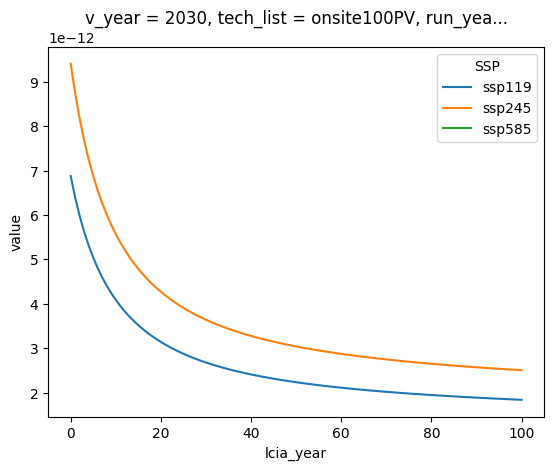

In [13]:
lcia_ds.sel(v_year = 2030, run_year = 2036, tech_list = "onsite100PV")['value'].plot(x='lcia_year', hue='SSP');

### C.3. to sum  Y1 - 100+TH impacts for each year

#### C.3.1. create a new empty ds with the correct dimension: 
- SSP -> 'ssp119' 'ssp126' 'ssp245' 'ssp585'
- v_year ->  2030 2040 2050
- v_module -> 'F2_fuel_elec'
- tech_list ->  'grid' 'onsite100PV'
- run_year -> no need for run_year, as it will be summed for final LCIA_year with a TH (100 + run_year)
- lcia_year -> initial LCIA_year (100) + run_year
- ensemble -> ds has 1001 as max. possible shape, though now we only have fixed CF values, so using ensemble = 0 when assigning

#### C.3.2. assign the data var dlcia to the ds for each / SSP / Year  /  lcia_year

In [14]:
all_sspYrunY_list = [] 
mod_toget = "F2_fuel_elec" 

for sp in lcia_ds['SSP'].values:
    for v_y  in lcia_ds['v_year'].values:
        for tech in lcia_ds['tech_list'].values:
            
            """ for each running year, need to prepare d-lcia scores """ 
            run_y_list = []
            for r_y in lcia_ds['run_year'].values:
                sel_ds = lcia_ds.sel(SSP = sp, v_year = v_y, tech_list = tech, run_year = r_y) 
                sel_ds1 = sel_ds.where(sel_ds['value'].notnull() , drop = True)
                if len(sel_ds1['value'].values) != 0 : 
                    run_y_list.append(sel_ds1['value'].values)
                else:
                    pass
            
            """ 1. add N * [0] for each future run_year so that it can be summed later """
            final_run_y_list, run_y_list_padded = [] , []
            for i in range(len(run_y_list)):  
                # Create a numpy array with i zeros, depending on future year position 
                shape = (i, )
                zeros = np.zeros(shape) 
                run_y_list_padded = np.concatenate((zeros, run_y_list[i]))
                """ 2. append each year to the final list, to sum later """ 
                final_run_y_list.append(run_y_list_padded)
            
            """ 3. sum over all running years' lcia score for TH:Year[0] + Year[100+lci_year] """ 
            allrun_y_lcia = [sum(filter(None, x)) for x in zip_longest(*final_run_y_list, fillvalue=0)]

            irf_score = np.array(allrun_y_lcia)
            crf_score_bad =  np.cumsum(allrun_y_lcia)

            # using cumtrapz for time-integral, more accurate to calculate CRF, slightly different from cumsum above 
            xt = np.arange(irf_score.shape[0])              
            crf_score = cumtrapz(irf_score, xt, initial=0)
            #print(crf_score_bad, "\n", crf_score)

            # wanna three data variables instead of 'dpLCA_IC' dimension, but for now it's a workout
            to_addvar_ds_shape = ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module': mod_toget, 'dpLCA_IC': 'dpIRF' , 'tech_list':tech, 'ensemble':0}].shape
            
            if to_addvar_ds_shape == irf_score.shape == crf_score.shape: 
                """ WHY ds can't assign data variable with diff. values, I wanna have three seperate variable (w/o)dpLCA_IC dim,  """ 
                #ds['dpIRF'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0 }]  = irf_score
                #ds['dpCRF'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0 }]  = crf_score

                for impact in  ['dpIRF', 'dpCRF', 'dpGWP']: 
                    if impact == "dpIRF": 
                        ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'dpLCA_IC':impact, 'ensemble':0 }]  = irf_score
                    elif impact == 'dpCRF': 
                        ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'dpLCA_IC':impact, 'ensemble':0 }]  = crf_score
                    else: 
                        print("no dpLCA score for dpGWP yet ")
                  
            else:
                print(f"no LCIA score added for tech {tech}, SSP{sp} v_year {v_y} as diff shape: {irf_score.shape}, {crf_score.shape}, {to_addvar_ds_shape} ")
                    

no dpLCA score for dpGWP yet 
no LCIA score added for tech onsite100PV, SSPssp119 v_year 2030 as diff shape: (115,), (115,), (120,) 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no LCIA score added for tech onsite100PV, SSPssp245 v_year 2030 as diff shape: (115,), (115,), (120,) 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 
no LCIA score added for tech onsite100PV, SSPssp585 v_year 2030 as diff shape: (105,), (105,), (120,) 
no dpLCA score for dpGWP yet 
no LCIA score added for tech onsite100PV, SSPssp585 v_year 2040 as diff shape: (115,), (115,), (120,) 
no dpLCA score for dpGWP yet 
no dpLCA score for dpGWP yet 


In [15]:
ds

<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, v_module: 1, tech_list: 2, lcia_year: 120,
                dpLCA_IC: 3, ensemble: 1001)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int64 2030 2040 2050
  * v_module   (v_module) <U12 'F2_fuel_elec'
  * tech_list  (tech_list) object 'grid' 'onsite100PV'
  * lcia_year  (lcia_year) int64 1 2 3 4 5 6 7 8 ... 114 115 116 117 118 119 120
  * dpLCA_IC   (dpLCA_IC) <U5 'dpIRF' 'dpCRF' 'dpGWP'
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    dplcia     (SSP, v_year, v_module, tech_list, lcia_year, dpLCA_IC, ensemble) float64 ...

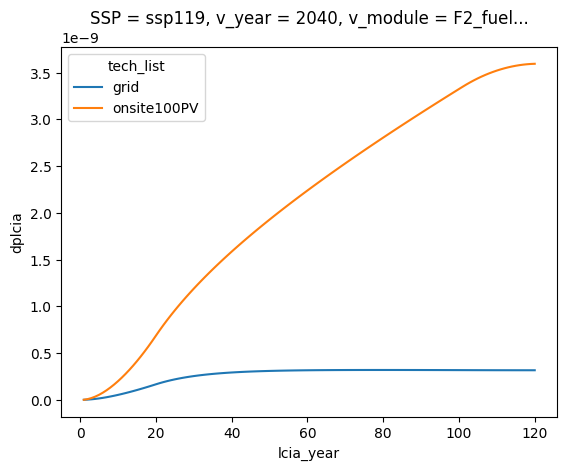

In [16]:
ds.sel(v_year = 2040, v_module = 'F2_fuel_elec', SSP = 'ssp119', dpLCA_IC = 'dpCRF', ensemble = 0 )["dplcia"].plot(x='lcia_year',  hue= 'tech_list'  );

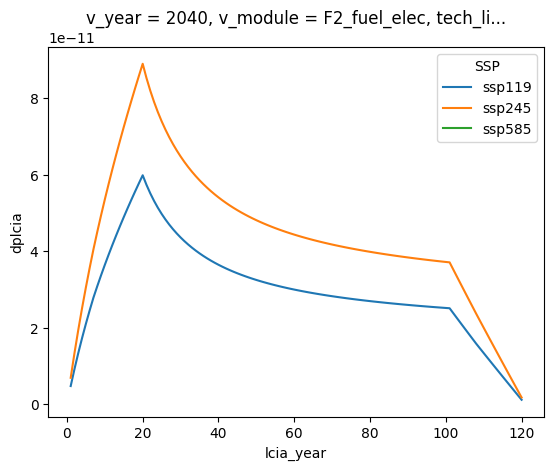

In [17]:
ds.sel(v_year = 2040, v_module = 'F2_fuel_elec', tech_list = 'onsite100PV', dpLCA_IC = 'dpIRF', ensemble = 0 )["dplcia"].plot(x='lcia_year',  hue= 'SSP'  );

In [18]:
ds.to_netcdf('../dlcia_output/F2_BEVGT_dpIRFCRF.nc')
d1.to_excel('../dlcia_output/excel_perRunYear/F2_BEVGT_dpIRFCRF_perSSPMY_perYEAR_perTech.xlsx', index = False)